#https://github.com/cornellius-gp/gpytorch/issues/1743
#[Question] Implementing multi-output multi-task approximate GP #1743

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
#%load_ext autoreload
#%autoreload 2

In [2]:
import os
import pandas as pd
from pandas import factorize
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats


In [3]:
class MultiOutputMultiTaskGP(gpytorch.models.ExactGP):

    def __init__(
        self,
        train_X,
        train_Y,
        likelihood,
        data_kernel = 'Matern',
        task_rank = None,
        output_rank = None
    ) -> None:

        num_outputs = train_Y.shape[-1]
        num_tasks = len(torch.unique(train_X[..., -1]))
        #batch_shape, ard_num_dims = train_X.shape[:-2], train_X.shape[-1]
                       
        #self._validate_tensor_args(X=train_X, Y=train_Y)

        super(MultiOutputMultiTaskGP, self).__init__(train_X, train_Y,likelihood)
        self.task_rank = task_rank if task_rank is not None else num_tasks
        self.output_rank = output_rank if output_rank is not None else num_outputs

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_outputs
        )
        
        if data_kernel == 'Matern':
            self.data_kernel = gpytorch.kernels.MaternKernel()
        else:
            self.data_kernel = gpytorch.kernels.RBFKernel()
        self.task_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank = self.task_rank) #default rank is 1
        self.output_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_outputs, rank = self.output_rank) #default rank is 1
        
        self.to(train_X)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        task_term = self.task_kernel(x[..., -1].long())
        data_and_task_x = self.data_kernel(x[..., :-1]).mul(task_term)
        output_x = self.output_kernel.covar_matrix
        covar_x = gpytorch.lazy.KroneckerProductLazyTensor(data_and_task_x, output_x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [8]:
t_train_x = torch.rand(16,6)
t_train_y = torch.rand(16,6)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
                num_tasks=6, 
                rank=0,
            )
mt_model = MultiOutputMultiTaskGP(t_train_x, t_train_y,likelihood)

mt_model_output = mt_model(*mt_model.train_inputs)
mt_out = mt_model.likelihood(mt_model_output).log_prob(mt_model.train_targets)

mt_model.named_priors

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403210267/work/torch/csrc/utils/tensor_new.cpp:620.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


<bound method Module.named_priors of MultiOutputMultiTaskGP(
  (likelihood): MultitaskGaussianLikelihood(
    (raw_task_noises_constraint): GreaterThan(1.000E-04)
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
  (mean_module): MultitaskMean(
    (base_means): ModuleList(
      (0-5): 6 x ConstantMean()
    )
  )
  (data_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (task_kernel): IndexKernel(
    (raw_var_constraint): Positive()
  )
  (output_kernel): IndexKernel(
    (raw_var_constraint): Positive()
  )
)>

## DOE Data

In [4]:
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
df = pd.read_csv('data/dps-cleaned-missing.csv')
print(len(df))
df.head()

1843


,Import_Date,ISID,Project,Protein,Modality,Control_Type,Stress_Condition,Temp_C_,Time_Days_,Well_ID,...,PI,MW,IMPORTED_DATA_FILE_NAME,TARGETS,REAGENT_TYPE,Simplified_Excipients,1st_Excipient_in_Sample,2nd_Excipient_in_Sample,_Conc_for_Excipient1,Origin_of_data
0,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B02,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
1,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B03,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
2,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B04,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
3,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B05,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
4,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B06,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary


In [23]:
df['Modality'].unique()

array(['mAb', 'BsAb', 'Fusion Protein', 'ADC', 'polymer conjugate',
       'Trispecific', 'Fab', nan], dtype=object)

In [6]:
cols_group = ['Project','Protein','Modality', 'Stress_Condition','Temp_C_', 'Time_Days_']
cols_feature01 = ['Buffer','NaCl_mM_', 'PS80_', 'Sucrose_','Trehalose_','pH']
cols_target = ['UP_SEC_Monomer','UP_SEC_HMW']
#cols_target = ['UP_SEC_HMW','UP_SEC_LMW']
cols_cate = ['Buffer','NaClRange','PS80_Range','Sucrose_Range','Trehalose_Range']

30
The list of indices greater than or equal to n_data_th : [1, 3, 5, 7, 8, 9, 10, 11]
8
224


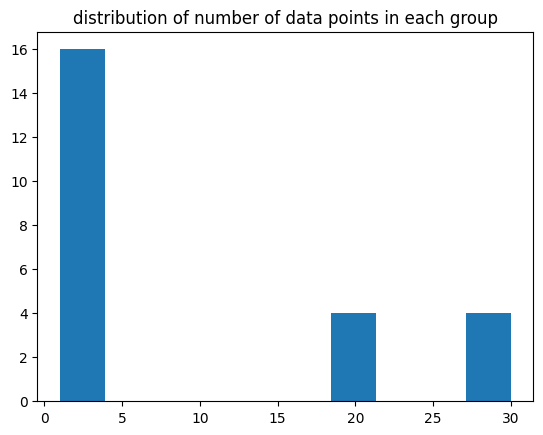

In [7]:
# split dataframe by identifiers
is_drop_na = True
if(is_drop_na):
    n_data_th = 20
else:
    n_data_th = 30
splits_identifier = list(df[cols_group + cols_feature01+cols_target].groupby(cols_group,dropna=is_drop_na))
#splits_identifier = list(df[cols_group + cols_cate+['pH']+cols_target].groupby(cols_group,dropna=is_drop_na))
ndata = [len(df[1]) for df in splits_identifier]
ndata_str = [str(e) for e in ndata]
#print(','.join(ndata_str))
plt.hist(ndata)
plt.title('distribution of number of data points in each group')
print(max(ndata))#21

res = [idx for idx, val in enumerate(ndata) if val >= n_data_th]
print("The list of indices greater than or equal to n_data_th : " + str(res))
print(len(res))
print(np.sum(ndata))

In [8]:
split1 = splits_identifier[1]
split3 = splits_identifier[3]
split5 = splits_identifier[5]

split1_formulation_df = split1[1][cols_feature01]
split1_formulation_df.reset_index(drop = True,inplace =True)
split3_formulation_df = split3[1][cols_feature01]
split3_formulation_df.reset_index(drop = True,inplace =True)
split5_formulation_df = split5[1][cols_feature01]
split5_formulation_df.reset_index(drop = True,inplace =True)


print(split1_formulation_df.equals(split3_formulation_df))
print(split3_formulation_df.equals(split5_formulation_df))

split1_target_df = split1[1][cols_target]
split1_target_df.reset_index(drop = True,inplace =True)
split1_target_df.columns = [c+'_1' for c in split1_target_df.columns]

split3_target_df = split3[1][cols_target]
split3_target_df.reset_index(drop = True,inplace =True)
split3_target_df.columns = [c+'_3' for c in split3_target_df.columns]

split5_target_df = split5[1][cols_target]
split5_target_df.reset_index(drop = True,inplace =True)
split5_target_df.columns = [c+'_5' for c in split5_target_df.columns]


True
True


In [9]:
#input space 8==9==11 != 10
split8 = splits_identifier[8]
split9 = splits_identifier[9]
split10 = splits_identifier[10]
split11 = splits_identifier[11]

split8_formulation_df = split8[1][cols_feature01]
split8_formulation_df.reset_index(drop = True,inplace =True)
split9_formulation_df = split9[1][cols_feature01]
split9_formulation_df.reset_index(drop = True,inplace =True)
split10_formulation_df = split10[1][cols_feature01]
split10_formulation_df.reset_index(drop = True,inplace =True)
split11_formulation_df = split11[1][cols_feature01]
split11_formulation_df.reset_index(drop = True,inplace =True)

print('----does 8 equal 9---')
print(split8_formulation_df.equals(split9_formulation_df)) 
print('----does 8 equal 10---')
print(split8_formulation_df.equals(split10_formulation_df))
print('----does 8 equal 11---')
print(split8_formulation_df.equals(split11_formulation_df))
print('----does 9 equal 10---')
print(split9_formulation_df.equals(split10_formulation_df))
print('----does 9 equal 11---')
print(split9_formulation_df.equals(split11_formulation_df))
print('----does 10 equal 11---')
print(split10_formulation_df.equals(split11_formulation_df))#! split 10 has a different input than 8,9,11

split8_target_df = split8[1][cols_target]
split8_target_df.reset_index(drop = True,inplace =True)
split8_target_df.columns = [c+'_8' for c in split8_target_df.columns]

split9_target_df = split9[1][cols_target]
split9_target_df.reset_index(drop = True,inplace =True)
split9_target_df.columns = [c+'_9' for c in split9_target_df.columns]

split10_target_df = split10[1][cols_target]
split10_target_df.reset_index(drop = True,inplace =True)
split10_target_df.columns = [c+'_10' for c in split10_target_df.columns]

split11_target_df = split11[1][cols_target]
split11_target_df.reset_index(drop = True,inplace =True)
split11_target_df.columns = [c+'_11' for c in split11_target_df.columns]

----does 8 equal 9---
True
----does 8 equal 10---
False
----does 8 equal 11---
True
----does 9 equal 10---
False
----does 9 equal 11---
True
----does 10 equal 11---
False


In [22]:
split1[1].head()

,Project,Protein,Modality,Stress_Condition,Temp_C_,Time_Days_,Buffer,NaCl_mM_,PS80_,Sucrose_,Trehalose_,pH,UP_SEC_Monomer,UP_SEC_HMW
289,FAP-TriNKET,DAB013887,BsAb,Thermal Stress,50.0,10.0,Acetate,0,0.0,0.0,0,5.0,98.09,1.45
290,FAP-TriNKET,DAB013887,BsAb,Thermal Stress,50.0,10.0,Acetate,0,0.0,0.0,0,5.5,97.96,1.37
291,FAP-TriNKET,DAB013887,BsAb,Thermal Stress,50.0,10.0,Acetate,0,0.0,0.0,0,6.0,98.15,1.24
292,FAP-TriNKET,DAB013887,BsAb,Thermal Stress,50.0,10.0,Citrate,0,0.0,0.0,0,5.5,97.66,1.42
293,FAP-TriNKET,DAB013887,BsAb,Thermal Stress,50.0,10.0,Citrate,0,0.0,0.0,0,6.0,98.03,1.63


In [12]:
split9[1].head()

,Project,Protein,Modality,Stress_Condition,Temp_C_,Time_Days_,Buffer,NaCl_mM_,PS80_,Sucrose_,Trehalose_,pH,UP_SEC_Monomer,UP_SEC_HMW
412,IL-2Ra,DNB553,Fusion Protein,Thermal Stress,40.0,12.0,Acetate,0,0.0,0.0,0,4.5,90.94,0.00
413,IL-2Ra,DNB553,Fusion Protein,Thermal Stress,40.0,12.0,Acetate,0,0.0,0.0,0,5.0,90.55,0.00
414,IL-2Ra,DNB553,Fusion Protein,Thermal Stress,40.0,12.0,Acetate,0,0.0,0.0,0,5.6,90.96,0.00
415,IL-2Ra,DNB553,Fusion Protein,Thermal Stress,40.0,12.0,Acetate,0,0.0,0.0,0,6.2,91.13,0.00
416,IL-2Ra,DNB553,Fusion Protein,Thermal Stress,40.0,12.0,Citrate,0,0.0,0.0,0,5.6,90.97,0.29


In [13]:
split10[1].head()

,Project,Protein,Modality,Stress_Condition,Temp_C_,Time_Days_,Buffer,NaCl_mM_,PS80_,Sucrose_,Trehalose_,pH,UP_SEC_Monomer,UP_SEC_HMW
443,IL-2Ra,DNB557,Fusion Protein,Thermal Stress,40.0,12.0,Acetate,0,0.0,0.0,0,4.5,89.57,0.0
444,IL-2Ra,DNB557,Fusion Protein,Thermal Stress,40.0,12.0,Acetate,0,0.0,0.0,0,5.0,90.07,0.0
445,IL-2Ra,DNB557,Fusion Protein,Thermal Stress,40.0,12.0,Acetate,0,0.0,0.0,0,5.6,89.91,0.0
446,IL-2Ra,DNB557,Fusion Protein,Thermal Stress,40.0,12.0,Histidine,0,0.0,0.0,0,5.0,89.14,0.0
447,IL-2Ra,DNB557,Fusion Protein,Thermal Stress,40.0,12.0,Acetate,0,0.0,0.0,0,6.2,89.73,0.0


In [14]:
split11[1].head()

,Project,Protein,Modality,Stress_Condition,Temp_C_,Time_Days_,Buffer,NaCl_mM_,PS80_,Sucrose_,Trehalose_,pH,UP_SEC_Monomer,UP_SEC_HMW
474,IL-2Ra,DNB558,Fusion Protein,Thermal Stress,40.0,12.0,Acetate,0,0.0,0.0,0,4.5,89.51,0.0
475,IL-2Ra,DNB558,Fusion Protein,Thermal Stress,40.0,12.0,Acetate,0,0.0,0.0,0,5.0,89.74,0.0
476,IL-2Ra,DNB558,Fusion Protein,Thermal Stress,40.0,12.0,Acetate,0,0.0,0.0,0,5.6,89.62,0.0
477,IL-2Ra,DNB558,Fusion Protein,Thermal Stress,40.0,12.0,Acetate,0,0.0,0.0,0,6.2,89.91,0.0
478,IL-2Ra,DNB558,Fusion Protein,Thermal Stress,40.0,12.0,Citrate,0,0.0,0.0,0,5.6,89.77,0.0


In [15]:


keep1_inds = np.abs(stats.zscore(split1_target_df['UP_SEC_HMW_1']))<3
keep3_inds = np.abs(stats.zscore(split3_target_df['UP_SEC_HMW_3']))<3
keep5_inds = np.abs(stats.zscore(split5_target_df['UP_SEC_HMW_5']))<3

split1_target_df = split1_target_df[(keep1_inds)]
split3_target_df = split3_target_df[(keep3_inds)]
split5_target_df = split5_target_df[(keep5_inds)]

split1_formulation_df = split1_formulation_df[(keep1_inds)]
split3_formulation_df = split3_formulation_df[(keep3_inds)]
split5_formulation_df = split5_formulation_df[(keep5_inds)]


In [31]:
print(split1_formulation_df.shape)
print(split3_formulation_df.shape)
print(split5_formulation_df.shape)

(20, 6)
(20, 6)
(20, 6)


In [ ]:
"""
keep8_inds = np.abs(stats.zscore(split8_target_df['UP_SEC_HMW_8']))<3
keep9_inds = np.abs(stats.zscore(split9_target_df['UP_SEC_HMW_9']))<3
keep10_inds = np.abs(stats.zscore(split10_target_df['UP_SEC_HMW_10']))<3
keep11_inds = np.abs(stats.zscore(split11_target_df['UP_SEC_HMW_11']))<3

split8_target_df = split8_target_df[(keep8_inds)]
split9_target_df = split9_target_df[(keep9_inds)]
split10_target_df = split10_target_df[(keep10_inds)]
split11_target_df = split11_target_df[(keep11_inds)]

split8_formulation_df = split8_formulation_df[(keep8_inds)]
split9_formulation_df = split9_formulation_df[(keep9_inds)]
split10_formulation_df = split10_formulation_df[(keep10_inds)]
split11_formulation_df = split11_formulation_df[(keep11_inds)]

print(split8_formulation_df.shape)
print(split9_formulation_df.shape)
print(split10_formulation_df.shape)
print(split11_formulation_df.shape)
"""


(29, 6)
(29, 6)
(29, 6)
(29, 6)


[None, None]

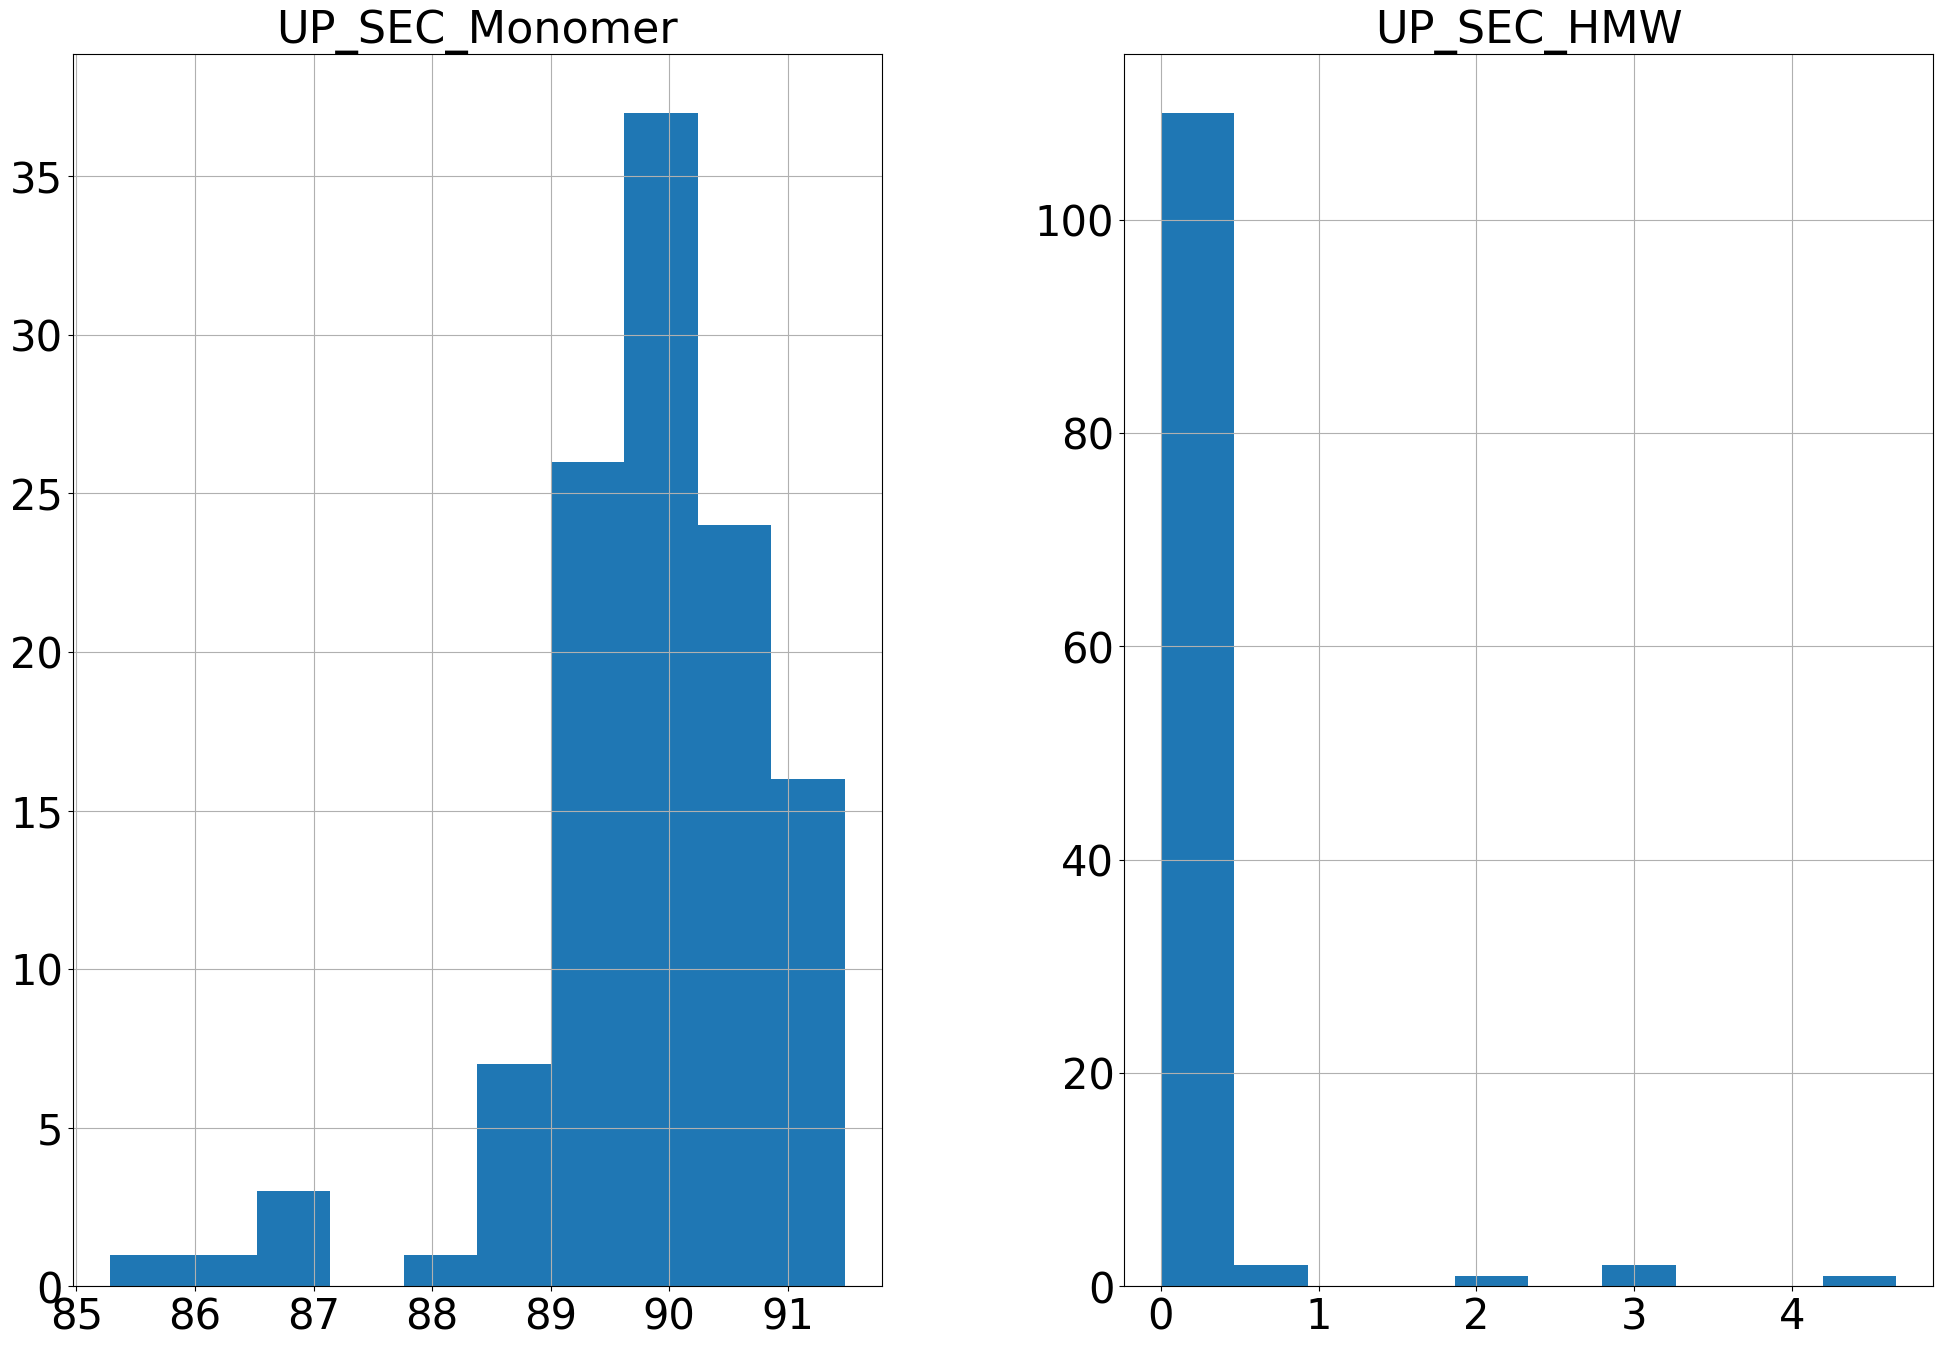

In [29]:
tmp_target_arr = np.concatenate([split8_target_df.to_numpy(),
                                 split9_target_df.to_numpy(),
                                 split10_target_df.to_numpy(),
                                 split11_target_df.to_numpy()])
tmp_target_arr.shape
tmp_target_df  = pd.DataFrame(tmp_target_arr,columns = cols_target)
#tmp_target_df.shape
#tmp_target_df.hist()

fig = tmp_target_df.hist(figsize = (24,16),xlabelsize = 30,ylabelsize=30)
[x.title.set_size(32) for x in fig.ravel()]

In [30]:
print(tmp_target_df.mean())
print(tmp_target_df.std())

UP_SEC_Monomer    89.852500
UP_SEC_HMW         0.162672
dtype: float64
UP_SEC_Monomer    1.019510
UP_SEC_HMW        0.619326
dtype: float64


array([[<Axes: title={'center': 'UP_SEC_Monomer_1'}>,
        <Axes: title={'center': 'UP_SEC_HMW_1'}>]], dtype=object)

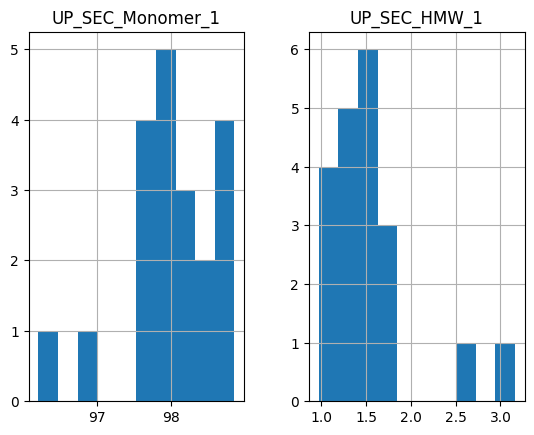

In [38]:
split1_target_df.hist()

array([[<Axes: title={'center': 'UP_SEC_Monomer_3'}>,
        <Axes: title={'center': 'UP_SEC_HMW_3'}>]], dtype=object)

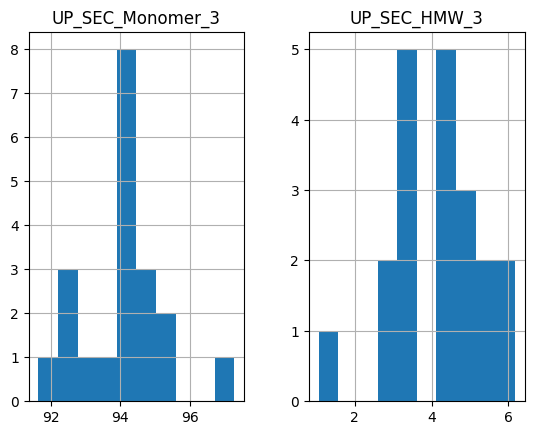

In [39]:
split3_target_df.hist()

array([[<Axes: title={'center': 'UP_SEC_Monomer_5'}>,
        <Axes: title={'center': 'UP_SEC_HMW_5'}>]], dtype=object)

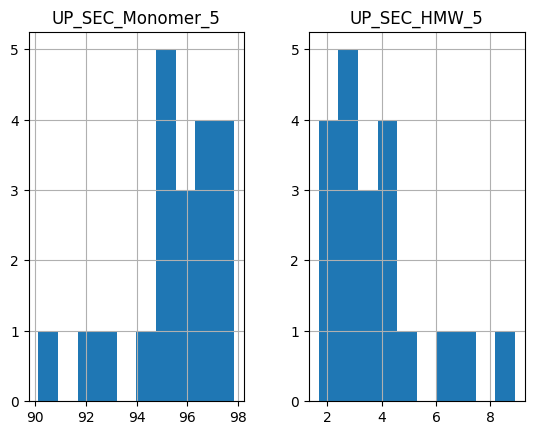

In [40]:
split5_target_df.hist()

In [18]:
#convert Buffer column to labels
x_name = 'Buffer'

cols_feature02 = ['Buffer_label', 'NaCl_mM_', 'PS80_', 'Sucrose_', 'Trehalose_', 'pH']
#cols_feature02 = ['Buffer_label', 'NaCl_mM_', 'pH']

In [11]:
n21_total_df = pd.concat((split1_formulation_df,split1_target_df,split3_target_df,split5_target_df),axis = 1)
#n21_total_df.head()
#convert Buffer column to labels
labels, categories = factorize(n21_total_df[x_name])
n21_total_df[x_name+"_label"] = labels

In [12]:
#onehot encoding
n21_total_df = pd.get_dummies(n21_total_df, columns = ['Buffer'])
print(n21_total_df.head())

n21_total_df['Buffer_Acetate'] = n21_total_df['Buffer_Acetate'].astype(int)
n21_total_df['Buffer_Citrate'] = n21_total_df['Buffer_Citrate'].astype(int)
n21_total_df['Buffer_Histidine'] = n21_total_df['Buffer_Histidine'].astype(int)
print(n21_total_df.head())


   NaCl_mM_  PS80_  Sucrose_  Trehalose_   pH  UP_SEC_Monomer_1  UP_SEC_HMW_1  \
0         0    0.0       0.0           0  5.0             98.09          1.45   
1         0    0.0       0.0           0  5.5             97.96          1.37   
2         0    0.0       0.0           0  6.0             98.15          1.24   
3         0    0.0       0.0           0  5.5             97.66          1.42   
4         0    0.0       0.0           0  6.0             98.03          1.63   

   UP_SEC_Monomer_3  UP_SEC_HMW_3  UP_SEC_Monomer_5  UP_SEC_HMW_5  \
0             97.27          1.06             95.21          3.86   
1             94.98          3.30             96.73          2.43   
2             94.86          3.60             97.36          1.82   
3             94.14          4.39             96.13          3.53   
4             94.01          4.59             96.04          2.90   

   Buffer_label  Buffer_Acetate  Buffer_Citrate  Buffer_Histidine  
0             0            Tru

In [19]:
n30_total_df = pd.concat((split8_formulation_df,split8_target_df,split9_target_df,split10_target_df,split11_target_df),axis = 1)
n30_total_df.head()

#convert Buffer column to labels
labels, categories = factorize(n30_total_df[x_name])
n30_total_df[x_name+"_label"] = labels


#onehot encoding
n30_total_df = pd.get_dummies(n30_total_df, columns = ['Buffer'])
print(n30_total_df.head())

n30_total_df['Buffer_Acetate'] = n30_total_df['Buffer_Acetate'].astype(int)
n30_total_df['Buffer_Citrate'] = n30_total_df['Buffer_Citrate'].astype(int)
n30_total_df['Buffer_Histidine'] = n30_total_df['Buffer_Histidine'].astype(int)
print(n30_total_df.head())

   NaCl_mM_  PS80_  Sucrose_  Trehalose_   pH  UP_SEC_Monomer_8  UP_SEC_HMW_8  \
0         0    0.0       0.0           0  4.5             90.71           0.0   
1         0    0.0       0.0           0  5.0             90.70           0.0   
2         0    0.0       0.0           0  5.6             90.64           0.0   
3         0    0.0       0.0           0  6.2             90.65           0.0   
4         0    0.0       0.0           0  5.6             91.04           0.0   

   UP_SEC_Monomer_9  UP_SEC_HMW_9  UP_SEC_Monomer_10  UP_SEC_HMW_10  \
0             90.94          0.00              89.57            0.0   
1             90.55          0.00              90.07            0.0   
2             90.96          0.00              89.91            0.0   
3             91.13          0.00              89.14            0.0   
4             90.97          0.29              89.73            0.0   

   UP_SEC_Monomer_11  UP_SEC_HMW_11  Buffer_label  Buffer_Acetate  \
0              89

In [21]:
29*4

116

In [107]:
"""
model_option = 3 #multi-task-multi-input-multi-output
x_scale_option = 1 #minMax
y_scale_option = 1 #scaling
cate_transform_option = 1 #
remove_pred_outlier_option = 0 #do not remove
rank_option = 0 #rank = 1, only one latent function for all outputs
split_option = 0
stratify_option = 0

model_label = ls_model[model_option]
x_scale_label = ls_x_scale[x_scale_option]
y_scale_label = ls_y_scale[y_scale_option]
cate_transform_label = 'cate_transform_'+ls_cate_transform[cate_transform_option]
remove_pred_outlier_label = 'remove_pred_outlier_'+str(ls_remove_pred_outlier[remove_pred_outlier_option])
rank_label = 'rank_'+str(ls_rank_option[rank_option])
split_label = ls_split_option[split_option]
stratify_label = ls_stratify_task[stratify_option]
"""

ls_model = ['simpleGP','multi-task-single-output','multi-task-multi-output','multi-task-multi-input-multi-output']
ls_x_scale = ['no-x-scale','x-minmax','x-stand','x-robust']
ls_y_scale = ['no-y-scale','y-minmax','y-stand','y-robust']
ls_cate_transform = ['label','ohe','LVGP','LMGP']
ls_remove_pred_outlier = [0,1]
ls_output_rank_option = [1,2]
ls_task_rank_option = [1,2,3,4,5,6,7]
ls_lik_rank_option = [0,1,2]
ls_split_option = ['mix','separate'] #mix: combine all tasks first then do train, test split (could stratify task?) #separate, do train-test-split first, then combine tasks
ls_stratify_task = ['not-stratify','stratify']


model_option = 'multi-task-multi-input-multi-output'
x_scale_option = 'x-minmax'
y_scale_option = 'y-robust'
cate_transform_option = 'ohe'
remove_pred_outlier_option= 0
output_rank_option = 1
task_rank_option = 1
lik_rank_option = 0
split_option = 'mix'
stratify_option = 'not-stratify'

model_label = model_option
x_scale_label = x_scale_option
y_scale_label = y_scale_option
cate_transform_label = 'cate_transform_'+cate_transform_option
remove_pred_outlier_label = 'remove_pred_outlier_'+str(remove_pred_outlier_option)
output_rank_label = 'output_rank_'+str(output_rank_option)
task_rank_label = 'task_rank_'+str(task_rank_option)
lik_rank_label = 'lik_rank_'+str(lik_rank_option)
split_label = split_option
stratify_label = stratify_option

folder_name = '-'.join([model_label,task_rank_label,output_rank_label,lik_rank_label,x_scale_label,y_scale_label,cate_transform_label,
                        remove_pred_outlier_label,split_label,stratify_label])

figPath = 'output-n21/'+folder_name
if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)

Creating folder output-n21/multi-task-multi-input-multi-output-task_rank_1-output_rank_1-lik_rank_0-x-minmax-y-robust-cate_transform_ohe-remove_pred_outlier_0-mix-not-stratify


In [108]:
if cate_transform_option == 'label':
    cols_feature_new = cols_feature02
else:
    cols_feature_new = ['Buffer_Acetate','Buffer_Citrate','Buffer_Histidine','NaCl_mM_', 'PS80_', 'Sucrose_', 'Trehalose_', 'pH']
"""
cols_target_new = ['UP_SEC_Monomer_1','UP_SEC_HMW_1',
                   'UP_SEC_Monomer_3','UP_SEC_HMW_3',
                   'UP_SEC_Monomer_5','UP_SEC_HMW_5',
                   'UP_SEC_Monomer_8','UP_SEC_HMW_8',
                   'UP_SEC_Monomer_9','UP_SEC_HMW_9',
                   'UP_SEC_Monomer_10','UP_SEC_HMW_10',
                   'UP_SEC_Monomer_11','UP_SEC_HMW_11']

cols_target_new = ['UP_SEC_Monomer_8','UP_SEC_HMW_8',
                   'UP_SEC_Monomer_9','UP_SEC_HMW_9',
                   'UP_SEC_Monomer_10','UP_SEC_HMW_10',
                   'UP_SEC_Monomer_11','UP_SEC_HMW_11']
"""
cols_target_new = ['UP_SEC_Monomer_1','UP_SEC_HMW_1',	
                   'UP_SEC_Monomer_3',	'UP_SEC_HMW_3',	
                   'UP_SEC_Monomer_5',	'UP_SEC_HMW_5']
#cols_target_new = ['UP_SEC_HMW_1','UP_SEC_LMW_1',	'UP_SEC_HMW_3',	'UP_SEC_LMW_3','UP_SEC_HMW_5','UP_SEC_LMW_5']

if split_label == 'mix':
    ls_X = [n21_total_df[cols_feature_new],
            n21_total_df[cols_feature_new],
            n21_total_df[cols_feature_new]]
    """
    ls_X = [n21_total_df[cols_feature_new],n21_total_df[cols_feature_new],n21_total_df[cols_feature_new],
            n30_total_df[cols_feature_new],n30_total_df[cols_feature_new],n30_total_df[cols_feature_new],
            n30_total_df[cols_feature_new]]
    
    ls_X = [n30_total_df[cols_feature_new],n30_total_df[cols_feature_new],
            n30_total_df[cols_feature_new],n30_total_df[cols_feature_new]]
    """
    for i,df_x in enumerate(ls_X):
        df_x['task_ind'] = i

    df_X = pd.concat(ls_X)
    df_X.reset_index(inplace=True, drop = True)
    print(df_X.head())

    arr_Y = np.concatenate((split1_target_df.to_numpy(),
                            split3_target_df.to_numpy(),
                            split5_target_df.to_numpy()))
    """
    arr_Y = np.concatenate((split1_target_df.to_numpy(),split3_target_df.to_numpy(),split5_target_df.to_numpy(),
                            split8_target_df.to_numpy(),split9_target_df.to_numpy(),split10_target_df.to_numpy(),
                            split11_target_df.to_numpy()))
    
    arr_Y = np.concatenate((split8_target_df.to_numpy(),split9_target_df.to_numpy(),split10_target_df.to_numpy(),
                            split11_target_df.to_numpy()))
    """
    df_Y = pd.DataFrame(arr_Y,columns= cols_target)
    print(df_Y.head())

else:
    df_X = n21_total_df[cols_feature02]
    print(df_X.head())

    df_Y = n21_total_df[cols_target_new]
    print(df_Y.head())

   Buffer_Acetate  Buffer_Citrate  Buffer_Histidine  NaCl_mM_  PS80_  \
0               1               0                 0         0    0.0   
1               1               0                 0         0    0.0   
2               1               0                 0         0    0.0   
3               0               1                 0         0    0.0   
4               0               1                 0         0    0.0   

   Sucrose_  Trehalose_   pH  task_ind  
0       0.0           0  5.0         0  
1       0.0           0  5.5         0  
2       0.0           0  6.0         0  
3       0.0           0  5.5         0  
4       0.0           0  6.0         0  
   UP_SEC_Monomer  UP_SEC_HMW
0           98.09        1.45
1           97.96        1.37
2           98.15        1.24
3           97.66        1.42
4           98.03        1.63


/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_19365/683429621.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['task_ind'] = i
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_19365/683429621.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['task_ind'] = i
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_19365/683429621.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [109]:
#split train and test data
if split_label == 'mix' and stratify_label =='stratify':
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_Y, 
                                                                test_size=0.2, 
                                                                random_state=0,
                                                                stratify=df_X['task_ind'])
else:
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_Y, 
                                                                test_size=0.2, 
                                                                random_state=0)

In [110]:
#if ls_cate_transform[cate_transform_option] == 'LMGP':
if cate_transform_option == 'LMGP':
    arr_x_train_cate_latent = np.load('data/train_cate_latent.npy',allow_pickle= True)
    arr_x_test_cate_latent = np.load('data/test_cate_latent.npy',allow_pickle= True)

    task1_test_cate_latent = np.concatenate((arr_x_test_cate_latent[0,...],arr_x_test_cate_latent[1,...]),axis = 1)
    task3_test_cate_latent = np.concatenate((arr_x_test_cate_latent[2,...],arr_x_test_cate_latent[3,...]),axis = 1)
    task5_test_cate_latent = np.concatenate((arr_x_test_cate_latent[4,...],arr_x_test_cate_latent[5,...]),axis = 1)

    task1_train_cate_latent = np.concatenate((arr_x_train_cate_latent[0,...],arr_x_train_cate_latent[1,...]),axis = 1)
    task3_train_cate_latent = np.concatenate((arr_x_train_cate_latent[2,...],arr_x_train_cate_latent[3,...]),axis = 1)
    task5_train_cate_latent = np.concatenate((arr_x_train_cate_latent[4,...],arr_x_train_cate_latent[5,...]),axis = 1)

    ls_test_cate_latent = [task1_test_cate_latent,task3_test_cate_latent,task5_test_cate_latent]
    ls_train_cate_latent = [task1_train_cate_latent,task3_train_cate_latent,task5_train_cate_latent]

In [111]:
if split_label != 'mix':
    ls_df_X_train = [df_X_train.copy(),df_X_train.copy(),df_X_train.copy()]
    for i,df_x in enumerate(ls_df_X_train):
        df_x['task_ind'] = i
        df_x.reset_index(inplace=True, drop = True)
        if cate_transform_option == 'LMGP':
            df_x = df_x.drop('Buffer_label',axis = 1)
            df_x = pd.concat((pd.DataFrame(ls_train_cate_latent[i],columns = ['c1','c2','c3','c4']),df_x),axis = 1)
            ls_df_X_train[i] = df_x

    df_X_train = pd.concat(ls_df_X_train)
    df_X_train.reset_index(inplace=True, drop = True)
    #df_X_train_long.head()

    ls_df_X_test = [df_X_test.copy(),df_X_test.copy(),df_X_test.copy()]
    for i,df_x in enumerate(ls_df_X_test):
        df_x['task_ind'] = i
        df_x.reset_index(inplace=True, drop = True)
        if cate_transform_option == 'LMGP':
            df_x = df_x.drop('Buffer_label',axis = 1)
            df_x = pd.concat((pd.DataFrame(ls_test_cate_latent[i],columns = ['c1','c2','c3','c4']),df_x),axis = 1)
            ls_df_X_test[i] = df_x

    df_X_test = pd.concat(ls_df_X_test)
    df_X_test.reset_index(inplace=True, drop = True)
    #df_X_test_long.head()

    ls_df_y_train = [df_y_train.iloc[:,[0,1]],df_y_train.iloc[:,[2,3]],df_y_train.iloc[:,[4,5]]]
    for i,df_y in enumerate(ls_df_y_train):
        df_y.columns = cols_target
    df_y_train = pd.concat(ls_df_y_train)
    df_y_train.reset_index(inplace=True, drop = True)
    #df_y_train_long.head()

    ls_df_y_test = [df_y_test.iloc[:,[0,1]],df_y_test.iloc[:,[2,3]],df_y_test.iloc[:,[4,5]]]
    for i,df_y in enumerate(ls_df_y_test):
        df_y.columns = cols_target
    df_y_test = pd.concat(ls_df_y_test)
    df_y_test.reset_index(inplace=True, drop = True)
    #df_y_test_long.head()

array([[<Axes: title={'center': 'Buffer_Acetate'}>,
        <Axes: title={'center': 'Buffer_Citrate'}>,
        <Axes: title={'center': 'Buffer_Histidine'}>],
       [<Axes: title={'center': 'NaCl_mM_'}>,
        <Axes: title={'center': 'PS80_'}>,
        <Axes: title={'center': 'Sucrose_'}>],
       [<Axes: title={'center': 'Trehalose_'}>,
        <Axes: title={'center': 'pH'}>,
        <Axes: title={'center': 'task_ind'}>]], dtype=object)

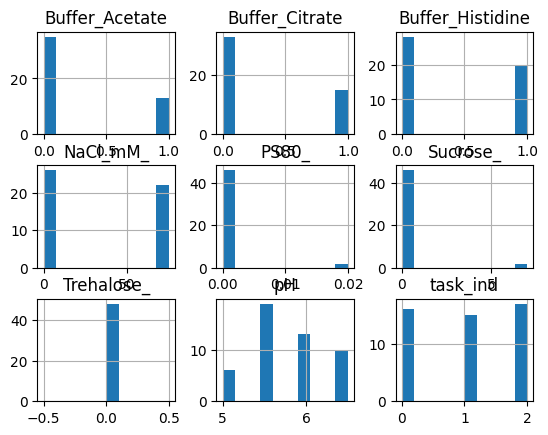

In [112]:
df_X_train.hist()

In [113]:
# scale features
#x_mm_scaler = MinMaxScaler()
#keep the last task indices column untouched !!!



xct = ColumnTransformer([('x_mm_scaler',MinMaxScaler(),df_X_train.columns.difference(['task_ind']))], 
                         remainder = 'passthrough')
#scaled_X_train=x_mm_scaler.fit_transform(df_X_train) 
#scaled_X_test=x_mm_scaler.transform(df_X_test)

scaled_X_train=xct.fit_transform(df_X_train) 
scaled_X_test=xct.transform(df_X_test)

#if y_scale_option==1:
if y_scale_label == 'y-robust':
    y_scaler = RobustScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-stand':
    y_scaler = StandardScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-minmax':
    y_scaler = MinMaxScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
else:
    scaled_y_train = df_y_train.to_numpy()
    scaled_y_test = df_y_test.to_numpy()

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
      dtype=object)

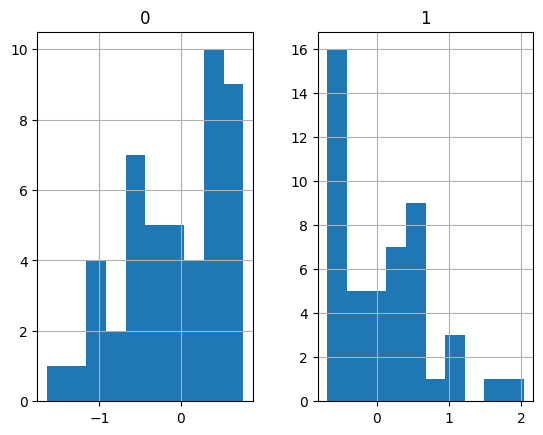

In [114]:
df_scaled_y_train = pd.DataFrame(scaled_y_train)
df_scaled_y_train.hist()

array([[<Axes: title={'center': 'UP_SEC_Monomer'}>,
        <Axes: title={'center': 'UP_SEC_HMW'}>]], dtype=object)

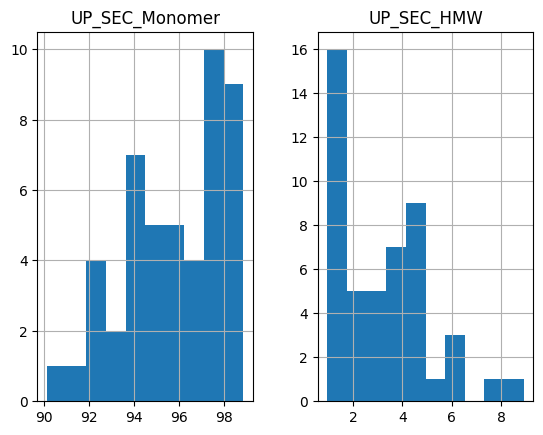

In [115]:
df_y_train.hist()

In [116]:
#if y_scale_option>0:
if y_scale_label != 'no-y-scale':
    t_train_y = torch.Tensor(scaled_y_train)
else:
    t_train_y = torch.Tensor(df_y_train.to_numpy())

#if x_scale_option>0:
if x_scale_label != 'no-x-scale':
    t_train_x = torch.Tensor(scaled_X_train)
else:
    t_train_x = torch.Tensor(df_X_train.to_numpy())
    

In [117]:
num_outputs = t_train_y.shape[-1]

task_rank = task_rank_option
output_rank = output_rank_option
lik_rank = lik_rank_option
if lik_rank is None:
            lik_rank = output_rank

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
                num_tasks=num_outputs, 
                rank=lik_rank if lik_rank is not None else 0,
            )

model = MultiOutputMultiTaskGP(t_train_x, t_train_y,likelihood,
                               task_rank = task_rank,output_rank = output_rank)

In [118]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 100
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(t_train_x)
    loss = -mll(output, t_train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 1.515
Iter 2/100 - Loss: 1.444
Iter 3/100 - Loss: 1.376
Iter 4/100 - Loss: 1.311
Iter 5/100 - Loss: 1.251
Iter 6/100 - Loss: 1.193
Iter 7/100 - Loss: 1.140
Iter 8/100 - Loss: 1.089
Iter 9/100 - Loss: 1.042
Iter 10/100 - Loss: 0.999
Iter 11/100 - Loss: 0.958
Iter 12/100 - Loss: 0.921
Iter 13/100 - Loss: 0.887
Iter 14/100 - Loss: 0.856
Iter 15/100 - Loss: 0.826
Iter 16/100 - Loss: 0.798
Iter 17/100 - Loss: 0.771
Iter 18/100 - Loss: 0.744
Iter 19/100 - Loss: 0.718
Iter 20/100 - Loss: 0.692
Iter 21/100 - Loss: 0.666
Iter 22/100 - Loss: 0.639
Iter 23/100 - Loss: 0.609
Iter 24/100 - Loss: 0.576
Iter 25/100 - Loss: 0.539
Iter 26/100 - Loss: 0.502
Iter 27/100 - Loss: 0.467
Iter 28/100 - Loss: 0.434
Iter 29/100 - Loss: 0.404
Iter 30/100 - Loss: 0.377
Iter 31/100 - Loss: 0.352
Iter 32/100 - Loss: 0.328
Iter 33/100 - Loss: 0.306
Iter 34/100 - Loss: 0.285
Iter 35/100 - Loss: 0.264
Iter 36/100 - Loss: 0.243
Iter 37/100 - Loss: 0.222
Iter 38/100 - Loss: 0.202
Iter 39/100 - Loss: 0

In [119]:

t_test_y = torch.Tensor(df_y_test.to_numpy())

if x_scale_option != 'no-x-scale':
    t_test_x = torch.Tensor(scaled_X_test)
else:
    t_test_x = torch.Tensor(df_X_test.to_numpy())


# Set into eval mode
model.eval()
likelihood.eval()

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [120]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = likelihood(model(t_test_x))   
        test_mean = test_pred.mean
        test_lower, test_upper = test_pred.confidence_region()
        train_pred = likelihood(model(t_train_x))
        train_mean = train_pred.mean
        train_lower, train_upper = train_pred.confidence_region()

        #t_std_train = train_mean - train_lower
        #t_std_test = test_mean - test_lower

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [121]:
if y_scale_option=='no-y-scale':
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = t_train_y.detach().numpy()
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()
    arr_test_mean = test_mean.detach().numpy()
    arr_test_lower = test_lower.detach().numpy()
    arr_test_upper = test_upper.detach().numpy()

    arr_train_mean = train_mean.detach().numpy()
    arr_train_lower = train_lower.detach().numpy()
    arr_train_upper = train_upper.detach().numpy()
else:
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = y_scaler.inverse_transform(t_train_y)
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()

    arr_train_mean = y_scaler.inverse_transform(train_mean)
    arr_train_lower = y_scaler.inverse_transform(train_lower)
    arr_train_upper = y_scaler.inverse_transform(train_upper)

    arr_test_mean = y_scaler.inverse_transform(test_mean)
    arr_test_lower = y_scaler.inverse_transform(test_lower)
    arr_test_upper = y_scaler.inverse_transform(test_upper)

##add a benchmark identity line

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_19365/1155483634.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'black')
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_19365/1155483634.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red')
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_19365/1155483634.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'black')
/var/folders/lk/7pxby8y145q_94s_03vn5cv80

         UP_SEC_Monomer_1  UP_SEC_HMW_1  UP_SEC_Monomer_3  UP_SEC_HMW_3  \
MAE                  0.39          0.40              0.70          0.50   
MAE2                 0.11          0.17              0.57          0.27   
MSE                  0.45          0.40              0.69          0.40   
RMSE                 0.67          0.64              0.83          0.63   
MAPE                 0.00          0.16              0.01          0.12   
MAXE                 1.33          1.24              1.46          0.98   
EVS                  0.39          0.39             -1.73          0.50   
R2                   0.26          0.30             -1.79          0.49   
AVG_STD              0.87          0.66              2.78          2.36   
MIN_STD              0.81          0.61              1.53          1.26   
MAX_STD              0.93          0.72              4.49          3.87   

         UP_SEC_Monomer_5  UP_SEC_HMW_5  
MAE                  0.84          0.73  
MAE2           

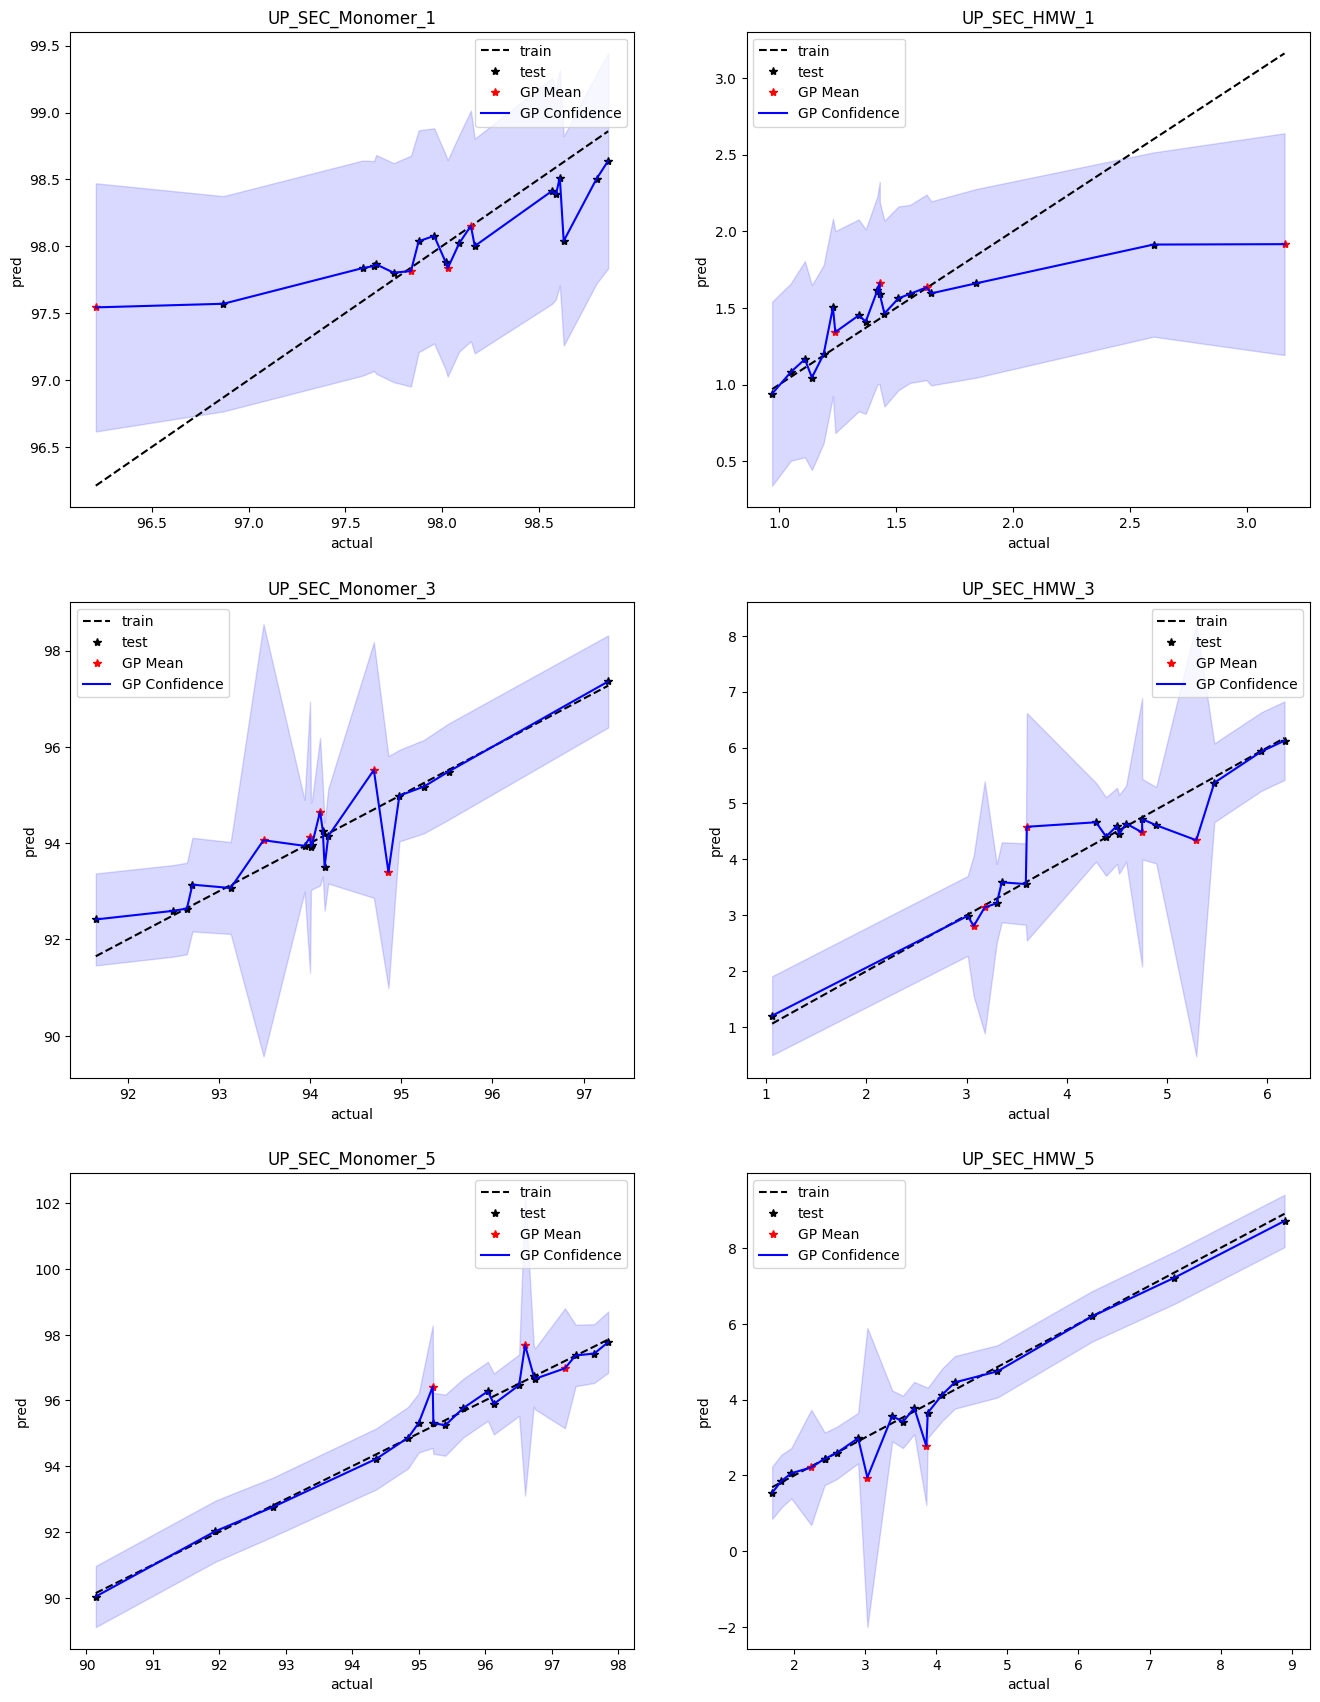

In [122]:
num_outputs = arr_train_y.shape[-1]
num_tasks = len(np.unique(arr_train_x[..., -1]))

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
#f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(16, 48))
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(16, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    tmp_col_y = cols_target_new[a]

    r_train_y = arr_train_y[arr_train_x[:,-1]==task_ind,j]
    r_train_mean_y =arr_train_mean[arr_train_x[:,-1]==task_ind,j]
    r_train_lower_y =arr_train_lower[arr_train_x[:,-1]==task_ind,j]
    r_train_upper_y =arr_train_upper[arr_train_x[:,-1]==task_ind,j]
    r_train_std = r_train_mean_y - r_train_lower_y

    r_test_y = arr_test_y[arr_test_x[:,-1]==task_ind,j]
    r_test_mean_y =arr_test_mean[arr_test_x[:,-1]==task_ind,j]
    r_test_lower_y =arr_test_lower[arr_test_x[:,-1]==task_ind,j]
    r_test_upper_y =arr_test_upper[arr_test_x[:,-1]==task_ind,j]
    r_test_std = r_test_mean_y - r_test_lower_y
    
    train_comp = np.concatenate((r_train_y.reshape(-1,1),r_train_mean_y.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = r_train_upper_y
    df_train_comp['lower'] = r_train_lower_y
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((r_test_y.reshape(-1,1),r_test_mean_y.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = r_test_upper_y
    df_test_comp['lower'] = r_test_lower_y
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    # Plot training data as black stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'black')

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red')
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    # Shade in confidence
    
    y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    y_axes[a].legend(['train','test','GP Mean', 'GP Confidence'])
    y_axes[a].set_title(tmp_col_y)
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')

    y_true = r_test_y
    y_pred = r_test_mean_y
    y_train = r_train_y
    mean_train = r_train_mean_y
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(r_test_std),2)
    arr_test_metrics[9,a] = round(np.min(r_test_std),2)
    arr_test_metrics[10,a] = round(np.max(r_test_std),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']


plt.savefig(figPath+'/true-pred.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)

df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')

Analyze the logic behind the model, dimension of intermediate output and final output

In [75]:
print('num_tasks',num_tasks)
print('num_outputs',num_outputs)
print('t_train_x',t_train_x.shape)

#model0 = MultiOutputMultiTaskGP(t_train_x,t_train_y,likelihood)
model0 = model

task_kern0 = model0.task_kernel
#the following two matrices are randomly intiated
covar_factor = task_kern0.covar_factor #this is the W matrix (B = WW^T + diag(v))
print('W matrix',covar_factor)
print('v',task_kern0.raw_var)
"""
self.register_parameter(
            name="covar_factor", parameter=torch.nn.Parameter(torch.randn(*self.batch_shape, num_tasks, rank))
        )
        self.register_parameter(name="raw_var", parameter=torch.nn.Parameter(torch.randn(*self.batch_shape, num_tasks)))
"""
print('v is transformed to the following through softplus operation') #task_kern0.raw_var_constraint.transform(task_kern0.raw_var)
var = task_kern0.var
print(var)

print('W W^T + diag(v) is the task kernel covariance matrix: ')
#res = PsdSumLinearOperator(RootLinearOperator(model0.task_kernel.covar_factor), DiagLinearOperator(var)) # covar_factor covar_factor^T + diag(var)
#print(res.evaluate())
B = task_kern0._eval_covar_matrix().detach().numpy()
print(B)

print('Correlation matrix between tasks')
C = (B/np.sqrt(np.diag(B))).T/np.sqrt(np.diag(B))
print(C)

print('print out dimensions of K(X,X), B(X,X)')
x = t_train_x

mean_x = model0.mean_module(x)
print('mean_x.shape',mean_x.shape) #(N_sample*D_task, D_output)

task_term =model0.task_kernel(x[..., -1].long())

task_term_value = task_term.evaluate()
print('task_term_value.shape',task_term_value.shape)
#task_term_value

data_term = model0.data_kernel(x[..., :-1])
data_term_value = data_term.evaluate()
print('data_term_value.shape',data_term_value.shape)

data_and_task_x = data_term.mul(task_term)
print('data_and_task_x.shape',data_and_task_x.shape)

output_x = model0.output_kernel.covar_matrix
print('output_x.shape',output_x.evaluate().shape)

covar_x = gpytorch.lazy.KroneckerProductLazyTensor(data_and_task_x, output_x)
covar_x_value = covar_x.evaluate()
print('covar_x_value.shape',covar_x_value.shape)

#output_x.shape: D_output*D_output
#task_term.shape: (N_sample*D_task,N_sample*D_task)
#self.data_kernal(x[..., -1]).shape: (N_sample*D_task,N_sample*D_task)
#data_and_task_x.shape: (N_sample*D_task,N_sample*D_task) 
#covar_x.shape: N_sample*D_task*D_output, N_sample*D_task*D_output



num_tasks 4
num_outputs 2
t_train_x torch.Size([92, 9])
W matrix Parameter containing:
tensor([[-1.8138],
        [-1.9165],
        [-2.9695],
        [-1.4183]], requires_grad=True)
v Parameter containing:
tensor([-2.5324, -0.0136, -1.1918, -2.9266], requires_grad=True)
v is transformed to the following through softplus operation
tensor([0.0765, 0.6864, 0.2652, 0.0522], grad_fn=<SoftplusBackward0>)
W W^T + diag(v) is the task kernel covariance matrix: 
[[3.366514  3.476187  5.3861628 2.5726557]
 [3.476187  4.3592477 5.6908994 2.7182105]
 [5.3861628 5.6908994 9.082919  4.2117195]
 [2.5726557 2.7182105 4.2117195 2.0638871]]
Correlation matrix between tasks
[[1.0000001  0.90741754 0.97403944 0.97599703]
 [0.90741754 1.         0.90440387 0.9062215 ]
 [0.97403944 0.90440387 1.         0.9727557 ]
 [0.9759971  0.9062215  0.9727556  1.0000001 ]]
print out dimensions of K(X,X), B(X,X)
mean_x.shape torch.Size([92, 2])
task_term_value.shape torch.Size([92, 92])
data_term_value.shape torch.Siz